# Part I - Prosper Loan Data
## by Neo Nakedi

## Introduction
> This data set contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others
>
> Prosper Marketplace is America's first peer-to-peer lending marketplace, with over USD7 billion in funded loans. Borrowers request personal loans on Prosper and investors (individual or institutional) can fund anywhere from USD2,000 to USD40,000 per loan request. Investors can consider borrowers’ credit scores, ratings, and histories and the category of the loan. Prosper handles the servicing of the loan and collects and distributes borrower payments and interest back to the loan investors.
>
> Prosper verifies borrowers' identities and select personal data before funding loans and manages all stages of loan servicing. Prosper's unsecured personal loans are fully amortized over a period of three or five years, with no pre-payment penalties. Prosper generates revenue by collecting a one-time fee on funded loans from borrowers and assessing an annual loan servicing fee to investors.
>
> <i>Source: [Wikipedia](https://en.wikipedia.org/wiki/Prosper_Marketplace) </i>


## 1. Preliminary Wrangling


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

#Pandas and Matplotlib settings
%matplotlib inline
font = {'size'   : 11} #Font size on plots
plt.rc('font', **font)

pd.set_option('display.float_format', lambda x: '%.2f' % x) #suppress scientific notation


### 1.1 Load the Prosper Loans datasets


In [2]:
df = pd.read_csv('Data/prosperLoanData.csv') #Load data
df_listingCategories=pd.read_excel('Data/ListingCategories.xlsx') # This created from the Variable definitions using GoogleSheets

#### 1.2 Assessing the structure of the dataset


In [3]:
#Head of the loans dataset
df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.17,0.16,0.14,...,-133.18,0.00,0.00,0.00,0.00,1.00,0,0,0.00,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12,0.09,0.08,...,0.00,0.00,0.00,0.00,0.00,1.00,0,0,0.00,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28,0.28,0.24,...,-24.20,0.00,0.00,0.00,0.00,1.00,0,0,0.00,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.13,0.10,0.09,...,-108.01,0.00,0.00,0.00,0.00,1.00,0,0,0.00,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.25,0.21,0.20,...,-60.27,0.00,0.00,0.00,0.00,1.00,0,0,0.00,20


In [4]:
#Review the shape
df.shape

(113937, 81)

The dataset appears to be imported correctly

In [5]:
#Review the information of the data, including data types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

There are 113,937 loans in this dataset with 81 features as listed above (`df.info()`).
It appears that they are incorrect datatypes on some fields. Dates are stored as objects instead of data/time

In [6]:
#Counting unique values in each field will assist us in identifying potential duplicates and possible categorical fields that may require ordering
pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])

,Column_Name,Num_Unique
22,CurrentlyInGroup,2
48,IncomeVerifiable,2
21,IsBorrowerHomeowner,2
4,Term,3
39,PublicRecordsLast12Months,7
...,...,...
2,ListingCreationDate,113064
62,LoanNumber,113066
50,LoanKey,113066
1,ListingNumber,113066


- All keys appear to be unique for each loan (`'ListingKey','ListingNumber','LoanKey' & 'LoanNumber'`)
- All the bool data types have two unique values as expected
- `'CreditGrade', 'IncomeRange', 'EmploymentStatus'` appear to be features that can be converted into ordered categorical types

### 1.3 The main features of interest in the dataset?

- The borrowers demographics `'EmploymentStatus' & 'StatedMonthlyIncome'`
- Assessing whether loan parameters  such as the `'BorrowersAPR', 'Term', 'LoanOriginalAmount', 'MonthlyLoanPayment','Lender's Yield ,'ProsperRating'`
- The Loan Dataset is support by another dataset that describes the variables(features). This has been imported as `df_def`
- From studying the variable definitions, it is clear that there were significant changes after July 2009. This means that it makes sense to subset the loan data after this date to ensure that our analysis is in-line with the new credit profiling variables.

### 1.4 Features in the dataset that will help support the investigation of features of interest?
- The borrowers demographic information is expected to have a relationship with the interest rate/APR, whilst the loan parameters are expected to drive the loan status, for example, whether the loan is completed, up-to-date or falling behind in arrears.
- Understanding the borrowers demographic and loan parameters may give insights as to the drivers of the APR and risk that the lender takes on

### 1.5 Data preparation tasks (wrangling)
- Datatypes: Fix incorrect data types on `'LoanOriginationDate'`. This will allow us to subset for data after July 2009, if the feature existed after that date.
- Define features: Add descriptions for `'ListingCategory'`. The dataset uses codes to describe the purpose of the loan, however to draw insights, we need to understand what these categories mean
- Create ordered Categories

In [7]:
#Datetime on LoanOriginationDate
df['LoanOriginationDate'] = pd.to_datetime(df['LoanOriginationDate'], format='%Y-%m-%d')

In [8]:
#Add description to 'ListingCategory
df = df.merge(df_listingCategories,right_on='ListingCategory',left_on='ListingCategory (numeric)')


In [9]:
df['EmploymentStatus'] = df['EmploymentStatus'].\
    astype(pd.api.types.CategoricalDtype(ordered = True,
                                         categories = ['Employed','Self-employed','Full-time','Part-time','Retired','Other','Not employed', 'Not available']))

In [10]:
#Ratio function
def ratio(dataframe,group,values,):
    x=pd.DataFrame(dataframe.groupby(group)[values].count().sort_values(ascending=False).reset_index())
    x['ratio']=x.iloc[:,-1]/x.iloc[:,-1].sum()
    return x

# Main question: What are the key variables that drive finance cost (BorrowersAPR)?
- The analysis below will attempt to answer this question using different univariate, bivariate and multivariate visualisations

## 2. Univariate Exploration

Overall distribution of variables

#### Univariate Exploration grid

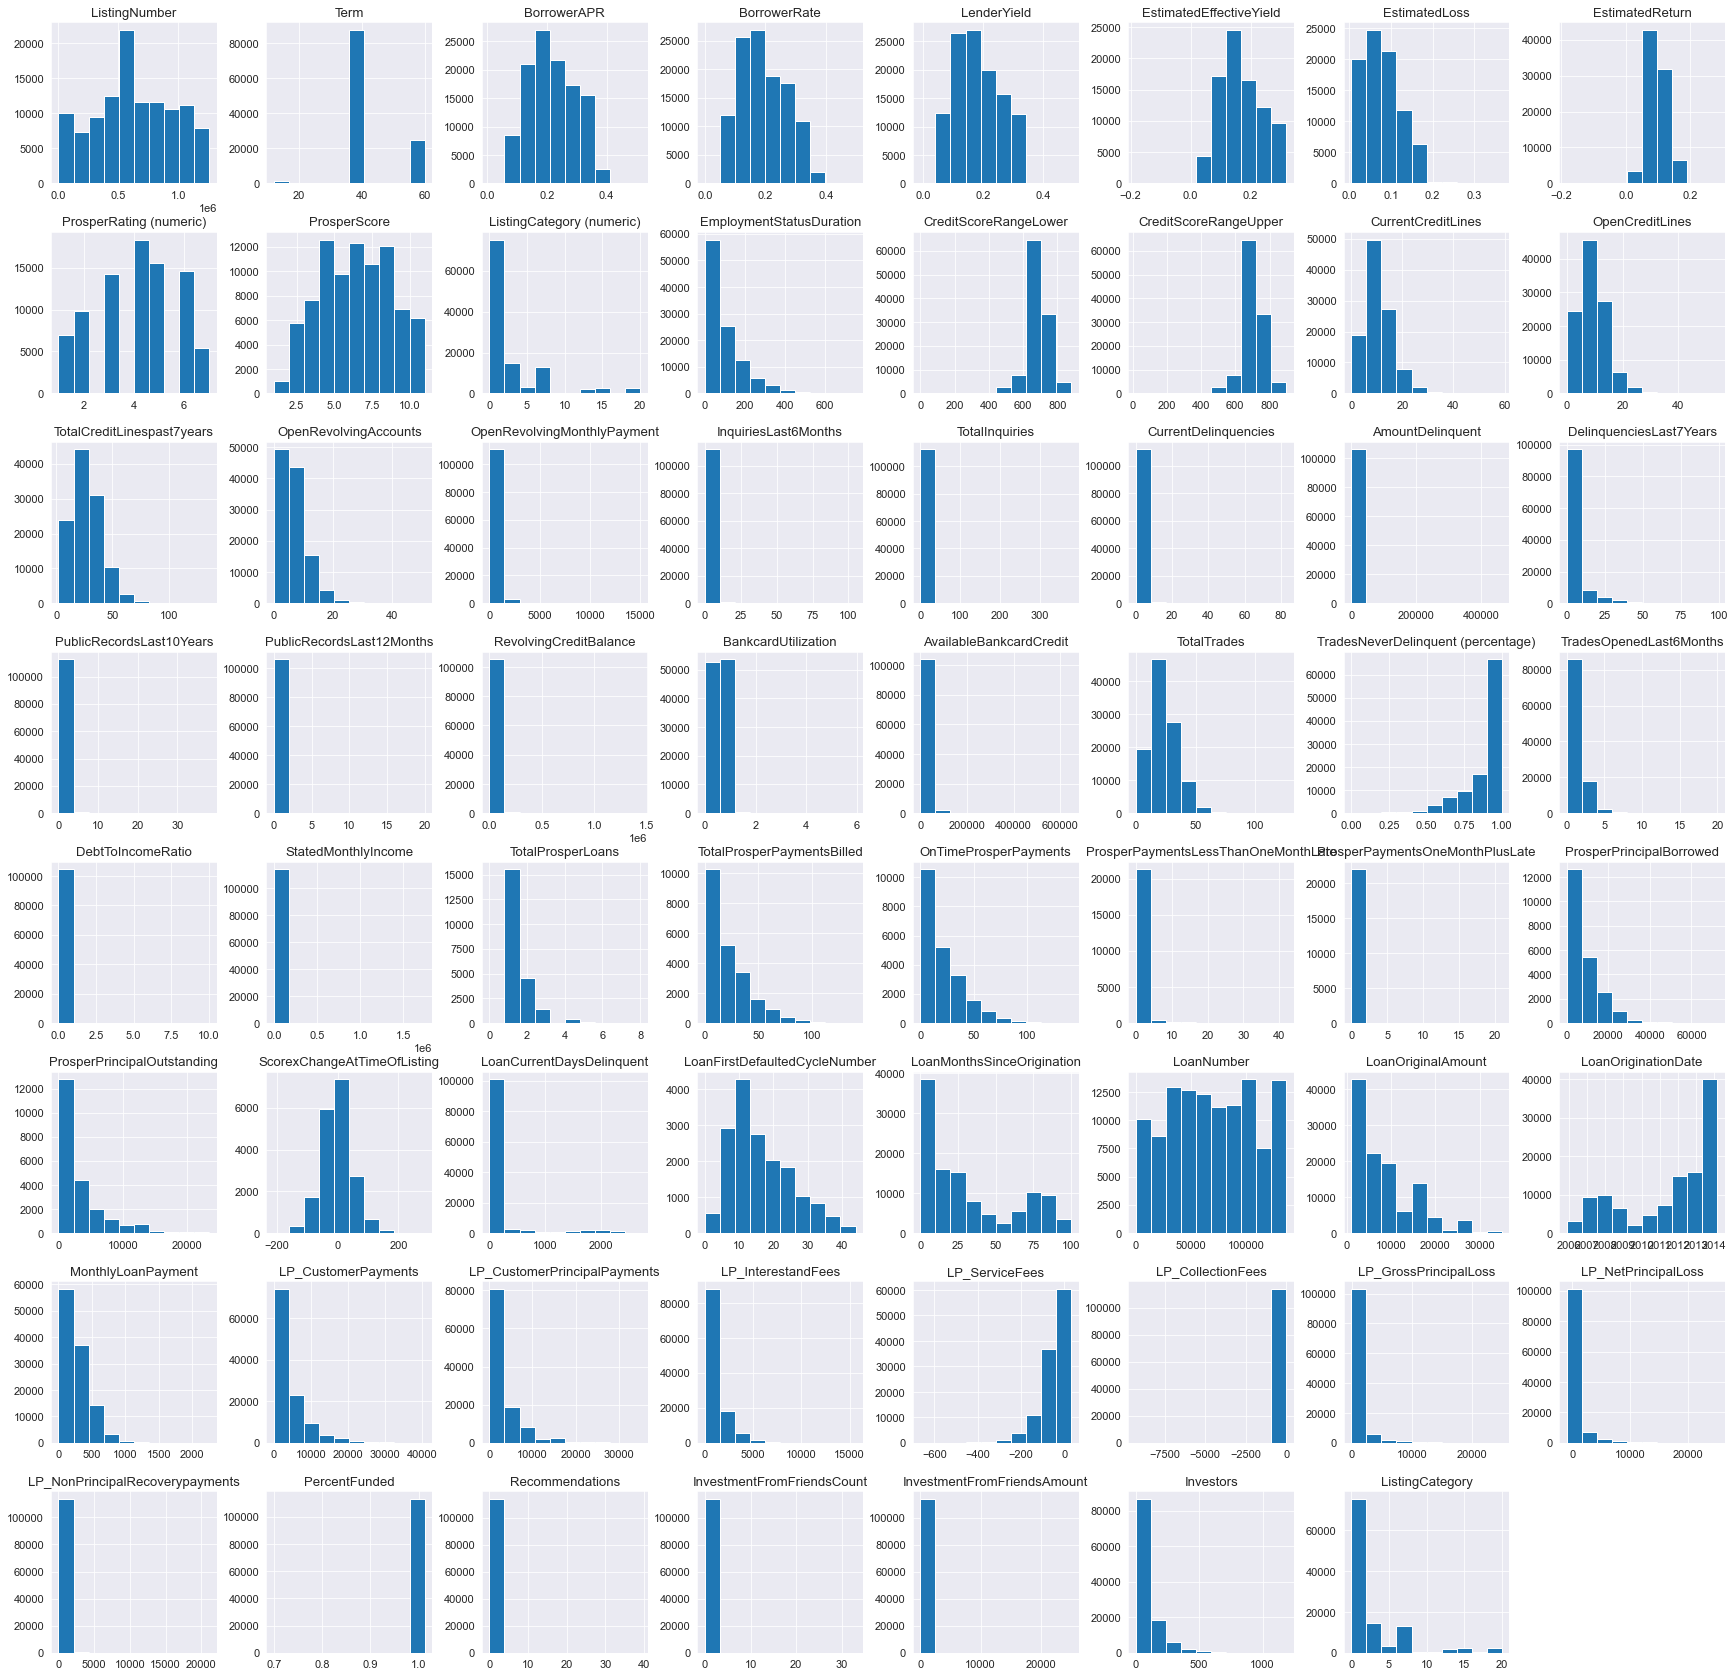

In [11]:
#Looking at the overall distribution picture of all univariate variables
df.hist(figsize=(30, 30));

<b>Observations:</b>
- BorrowerAPR, effective yield, ScorexChangeAtTimeOfListing, LoanFirstDefaultedCycleNumber amongst a few others show that these variable are normally distributed
- The remaining variables are screwed to the left of the or the right.
- The variables that are chosen in section 1 will be explored further below

#### 2.1 Borrower's APR - Univariate Exploration



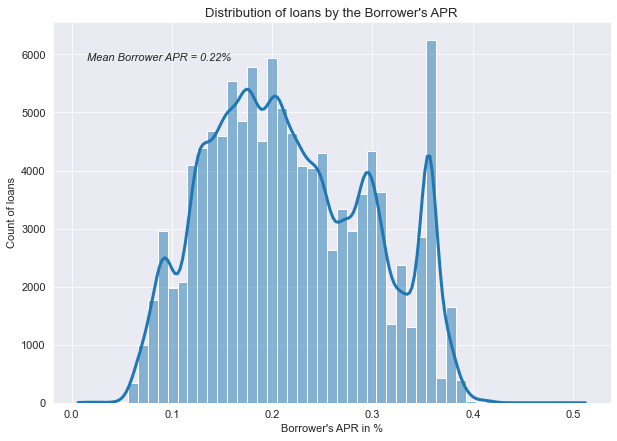

In [12]:
#Ploting a histogram of the distribution of the Borrower's APR
plt.figure(figsize=[10, 7])
#plt.hist(data = df, x = 'BorrowerRate', bins = int(abs(df['BorrowerAPR'].max()*100)), color='r')
sns.histplot(df['BorrowerAPR'], kde=True,line_kws={'color': 'red', 'lw': 3, 'ls': '-'}, bins=int(abs(df['BorrowerAPR'].max()*100)));
plt.xlabel("Borrower's APR in %")
plt.ylabel('Count of loans')
plt.title("Distribution of loans by the Borrower's APR")
plt.text(.015, 5900,f"Mean Borrower APR = {df['BorrowerAPR'].mean():.2f}%", style='italic')
plt.grid(True)
plt.show()

**Borrower's APR**
>- The APR has a spike around 0.35 but the rest of the loans are distributed multimodal  across the spectrum
>- The average rate is 0.22% with frequency appearing to be screwed more to the right

In [13]:
#Variable statistics
df['BorrowerAPR'].describe()

count   113912.00
mean         0.22
std          0.08
min          0.01
25%          0.16
50%          0.21
75%          0.28
max          0.51
Name: BorrowerAPR, dtype: float64

>- The maximum rate is 0.51%, which doesn't appear too extreme to be taken as an outlier

#### 2.2 ProsperRating - Univariate Exploration

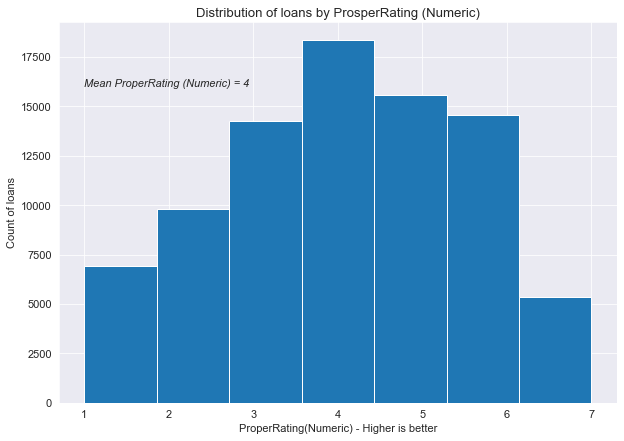

In [14]:
#Ploting a histogram of the distribution of the PropserRating(numeric)
plt.figure(figsize=[10, 7])
plt.hist(data = df, x = 'ProsperRating (numeric)', bins = int(abs(df['ProsperRating (numeric)'].max())))
plt.xlabel("ProperRating(Numeric) - Higher is better")
plt.ylabel('Count of loans')
plt.title("Distribution of loans by ProsperRating (Numeric)")
plt.text(1, 16000,f"Mean ProperRating (Numeric) = {df['ProsperRating (numeric)'].mean():.0f}", style='italic')
plt.grid(True)
plt.show()

<b>Observations:</b>
- The distribution of the loans according to ratings appear to be normally distributed with 4 being the average score.
- The graph is slightly screwed to the left where the ProsperRating is lower

#### 2.3 LoanOriginalAmount - Univariate Exploration

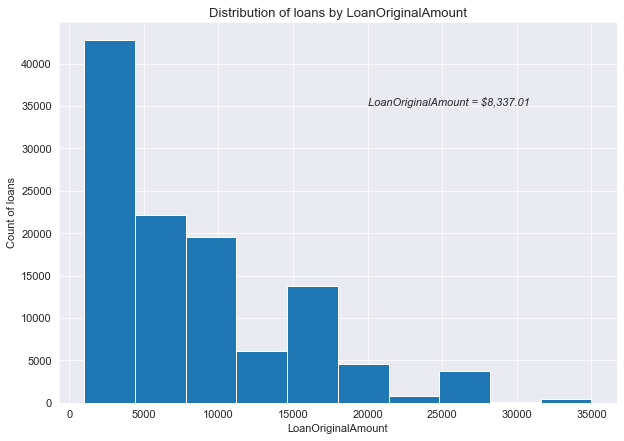

In [15]:
#Ploting a histogram of the distribution of the LoanOriginalAmount
plt.figure(figsize=[10, 7])
plt.hist(data = df, x = 'LoanOriginalAmount')
plt.xlabel("LoanOriginalAmount")
plt.ylabel('Count of loans')
plt.title("Distribution of loans by LoanOriginalAmount")
plt.text(20000, 35000,f"LoanOriginalAmount = ${df['LoanOriginalAmount'].mean():,.2f}", style='italic')
plt.grid(True)
plt.show()

<b>Observations:</b>
- The average borrowed amount is USD8,337.01
- More than 50% of loans range between USD 1.00 and USD10,000.00.
- The maximum loan amount appears to be USD35,000

#### 2.4 Stated Monthly Income - Univariate Exploration
Stated monthly income of the borrowers

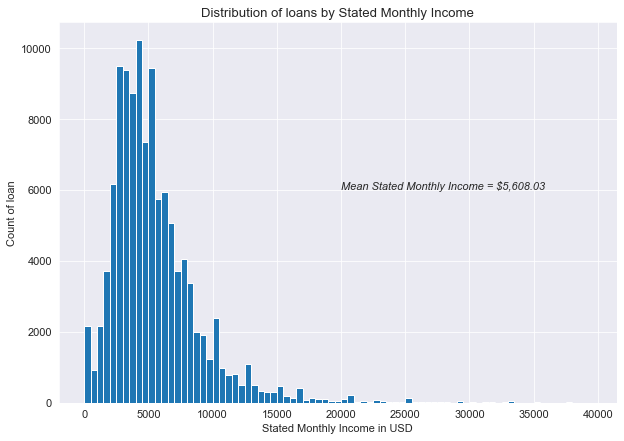

In [16]:
# Distribution of stated monthly income
bins = np.arange(0, 40000, 500)
plt.figure(figsize=[10, 7])
plt.hist(data=df, x='StatedMonthlyIncome', bins=bins);
plt.xlabel("Stated Monthly Income in USD")
plt.ylabel('Count of loan')
plt.title("Distribution of loans by Stated Monthly Income")
plt.text(20000, 6000,f"Mean Stated Monthly Income = ${df['StatedMonthlyIncome'].mean():,.2f}", style='italic')
plt.grid(True)
plt.show()

<b>Observations</b>
- The distribution is skewed to the left, with the average income sitting at USD5,608
- There are a few higher earners, earning USD 25,000 per month
- The average monthly income is lower than the borrowed amounts

In [17]:
#Variable Statistics
df['StatedMonthlyIncome'].describe()

count    113937.00
mean       5608.03
std        7478.50
min           0.00
25%        3200.33
50%        4666.67
75%        6825.00
max     1750002.92
Name: StatedMonthlyIncome, dtype: float64

- There are approximately 2,000 loans where there is no MonthlyStatedIncome, which appears to be irregular


#### 2.5 Term of loans - Univariate Exploration
Distribution of terms

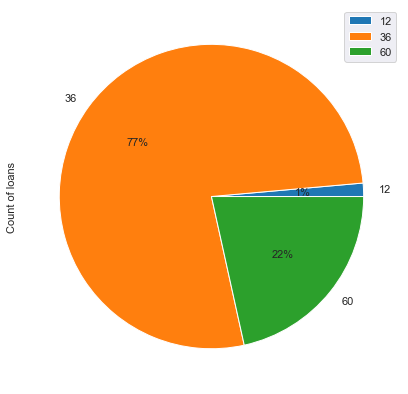

In [18]:
#Group the terms and see the % distribution of each term across the population
df.groupby(['Term']).count().plot(kind="pie", figsize=(7,7),autopct='%1.0f%%',y='ListingKey', ylabel='Count of loans');

<b>Observations:</b>
- 77% of the loans have a term of 36 months, followed by 22% in 60 months
- The terms of the loan appears to be categorical as either 12, 36 or 60, nothing in between.
- Only 1% of the population opt for 12-month loans.
- The loans are medium (36) to long-term (60) in nature

#### 2.6 Loan status - Univariate Exploration
Loan Status

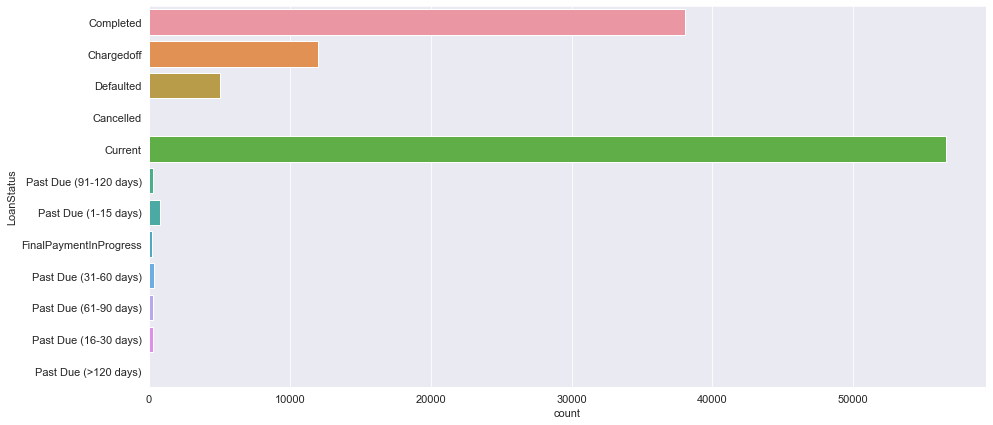

In [19]:
#Plot the loan status on an SNS countplot
plt.figure(figsize=[15, 7])
sns.countplot(data=df, y='LoanStatus');

<b>Observations:</b>
- Most loans are completed or in current. This means that a significant portion of the loans are in good standing

In [20]:

#Use of ratio function to assess the distribution of the loan status
ratio(df,'LoanStatus','ListingKey')


,LoanStatus,ListingKey,ratio
0,Current,56576,0.50
1,Completed,38074,0.33
2,Chargedoff,11992,0.11
3,Defaulted,5018,0.04
4,Past Due (1-15 days),806,0.01
5,Past Due (31-60 days),363,0.00
6,Past Due (61-90 days),313,0.00
7,Past Due (91-120 days),304,0.00
8,Past Due (16-30 days),265,0.00
9,FinalPaymentInProgress,205,0.00


- Loan book appears to be healthy, with a total of 83% in  current (50%) or completed (33%).
- Only 4% of the loans are in default, while around 1% is past due

#### 2.7 Employment status - Univariate Exploration

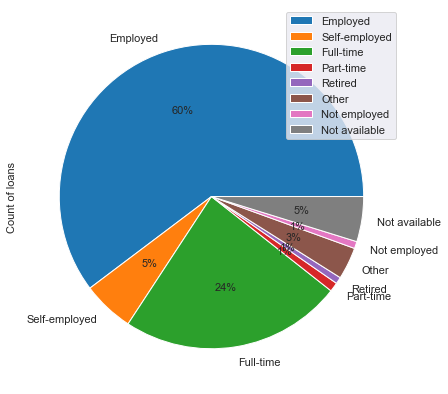

In [21]:
df.groupby(['EmploymentStatus']).count().plot(kind="pie", figsize=(12,7),autopct='%1.0f%%',y='ListingKey', ylabel='Count of loans');

<b>Observations:</b>
- 5% of the data is missing. This is unusual given the fact that earning potential is a key factor in granting credit
- Over 90% of the borrowers are in some form of employment

#### 2.8 Listing category - Univariate Exploration

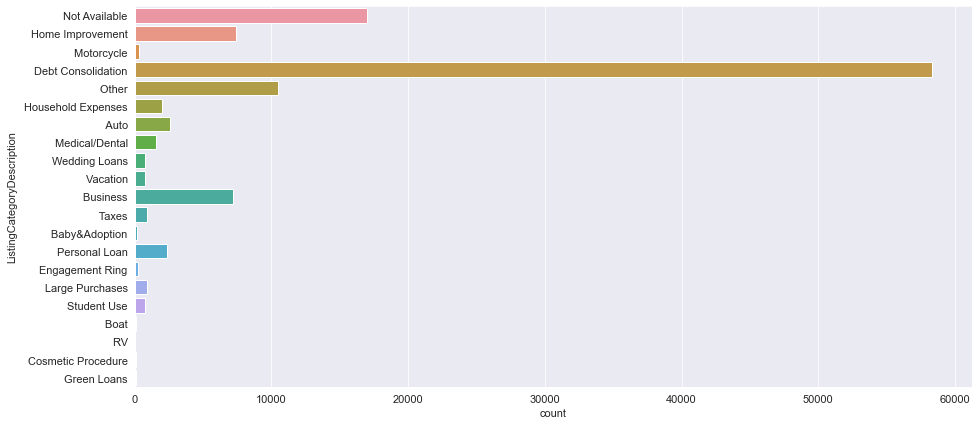

In [22]:
plt.figure(figsize=[15, 7])
sns.countplot(data=df, y='ListingCategoryDescription');

- Debt consolidation appears to be the leading listing category

In [23]:
df_var = df[['ListingKey', 'BorrowerAPR','BorrowerRate','ProsperRating (numeric)','LoanOriginalAmount','StatedMonthlyIncome',
             'Term','LoanStatus','EmploymentStatus','ListingCategoryDescription']]

In [24]:
df_var.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113937 entries, 0 to 113936
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   ListingKey                  113937 non-null  object  
 1   BorrowerAPR                 113912 non-null  float64 
 2   BorrowerRate                113937 non-null  float64 
 3   ProsperRating (numeric)     84853 non-null   float64 
 4   LoanOriginalAmount          113937 non-null  int64   
 5   StatedMonthlyIncome         113937 non-null  float64 
 6   Term                        113937 non-null  int64   
 7   LoanStatus                  113937 non-null  object  
 8   EmploymentStatus            111682 non-null  category
 9   ListingCategoryDescription  113937 non-null  object  
dtypes: category(1), float64(4), int64(2), object(3)
memory usage: 8.8+ MB


## Bivariate Exploration


#### 3.1 Bivariate pair grid of all variables

loans.shape= (113937, 10)
df_samp.shape= (5000, 10)


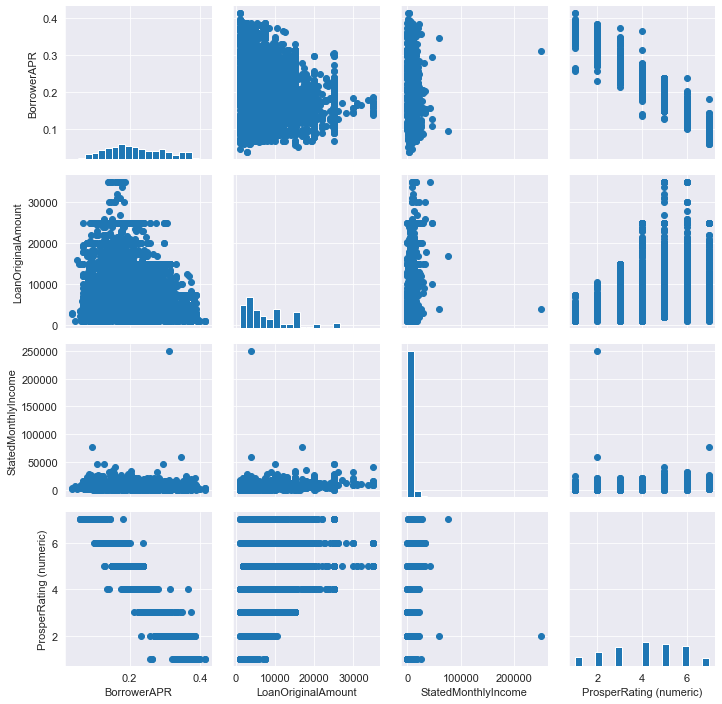

In [25]:
# plot matrix: sample 5000 loans
print("loans.shape=",df_var.shape)
df_samp = df_var.sample(n=5000, replace = False)
print("df_samp.shape=",df_samp.shape)

numeric_vars = ['BorrowerAPR', 'LoanOriginalAmount', 'StatedMonthlyIncome', 'ProsperRating (numeric)']

g = sns.PairGrid(data = df_samp, vars = numeric_vars)
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(plt.scatter)

<b>Observations:</b>
- The BorrowAPR and ProsperRating pairgrid shows that there is a positive correlation.
- The BorrowerAPR is higher for as the ProsperRating increases
- Borrowers with a higher PropserRating appear to have larger OriginalLoanAmounts. This means that people with stronger ratings tend to to be approved for higher amounts.
- The remaining variables have weak correlations

#### 3.1 Heatmap of variables

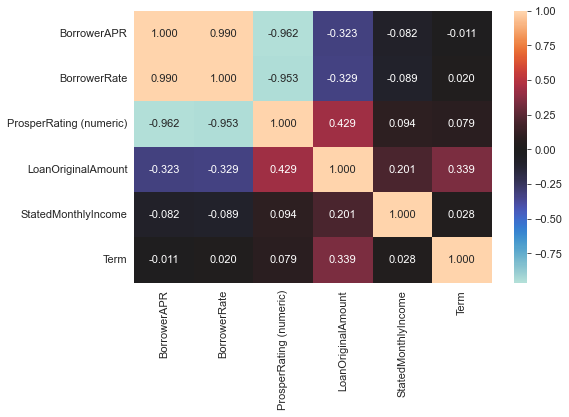

In [26]:
# correlation plot
plt.figure(figsize = [8, 5])
sns.heatmap(df_var.corr(), annot = True, fmt = '.3f', center = 0);

<b>Observations:</b>
- A lot of the chosen variables appear to have weak correlations
- The strongest positive correlations come from the ProsperRatings and BorrowerAPR and Rates
- Credit ratings appear to be the biggest driver of financing cost (BorrowerAPR)
- OriginalLoanAmount also has a slightly weaker positive correlation

#### 3.2 BorrowerAPR vs ProsperRating - Bivariate

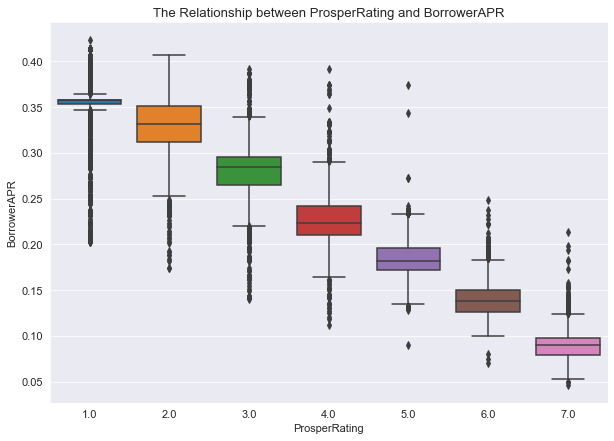

In [27]:
# boxplot Borrower APR vs ProsperRating
plt.figure(figsize=[10, 7])
sns.boxplot(x=df['ProsperRating (numeric)'],y=df['BorrowerAPR']);
plt.title('The Relationship between ProsperRating and BorrowerAPR')
plt.xlabel('ProsperRating')
plt.ylabel('BorrowerAPR')
plt.show();

<b>Observations:</b>
- The lower the ProsperRating, the higher the BorrowerAPR. Positive correlation
- Risky borrowers pay higher interest as expected

#### 3.3 BorrowerAPR vs Employment Status - Bivariate

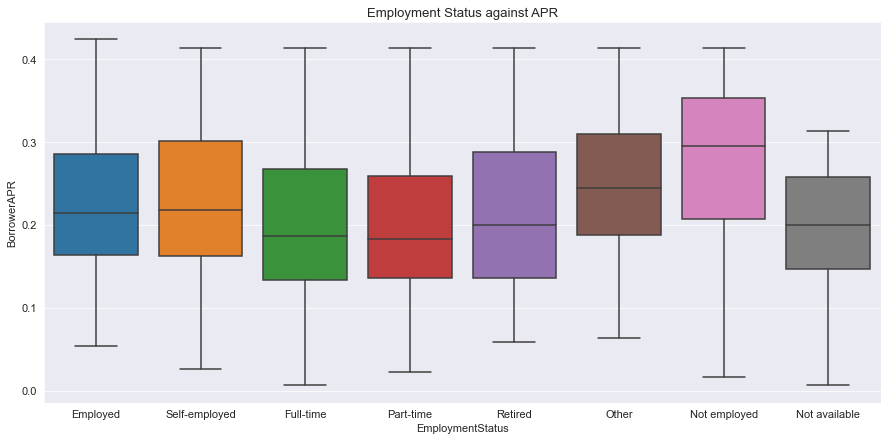

In [28]:
#Box plot of employment statuses against BorrowerAPR
plt.figure(figsize = [15, 7])
plt.title('Employment Status against APR')
sns.boxplot(x=df['EmploymentStatus'], y = df['BorrowerAPR']);

<b>Observations:</b>
- Full-time and part-time employees appear to have the lowest BorrowerAPR average, hovering below 0.2%
- Surprisingly, where data is unavailable, the borrower APR is at 0.2% with the maximum just above 0.3%
- Full-time employees have the widest range with minimums and maximums on the extreme ends of the spectrum

#### 3.4 BorrowerAPR vs Stated Monthly Income - Bivariate

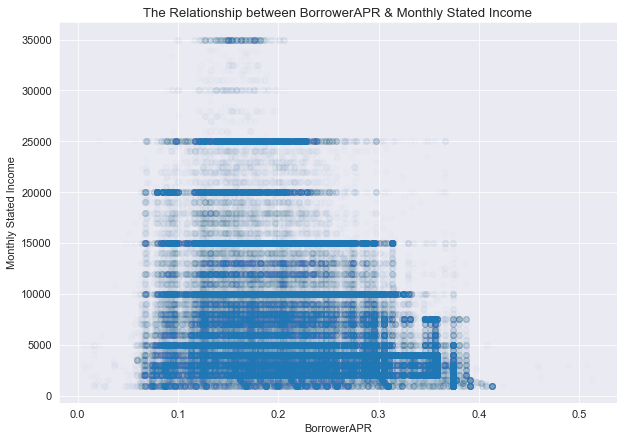

In [29]:
# Scatterplot BorrowerAPR vs Stated Montly Income

df_lim=df[df['StatedMonthlyIncome']<30000]
plt.figure(figsize=[10, 7])
plt.scatter(df_lim['BorrowerAPR'],df_lim['LoanOriginalAmount'], alpha=0.01);
plt.title('The Relationship between BorrowerAPR & Monthly Stated Income')
plt.xlabel('BorrowerAPR')
plt.ylabel('Monthly Stated Income')
plt.show();

<b>Observations:</b>
- The correlation between MonthlyStatedIncome and BorrowerAPR is weak, there are some observable insights
- The higher the monthly income, the narrower the range of the BorrowerAPR.
- The BorrowerAPR is much more favourable to higher Monthly Income earners, despite the weak correlation

#### 3.4 Other Bivariate comparisons for enrichment (Categorical Variables)
- 3.4.1 - Employment status vs loan term
- 3.4.2 - Employment status vs loan status
- 3.4.3 - Loan term vs ProsperRating

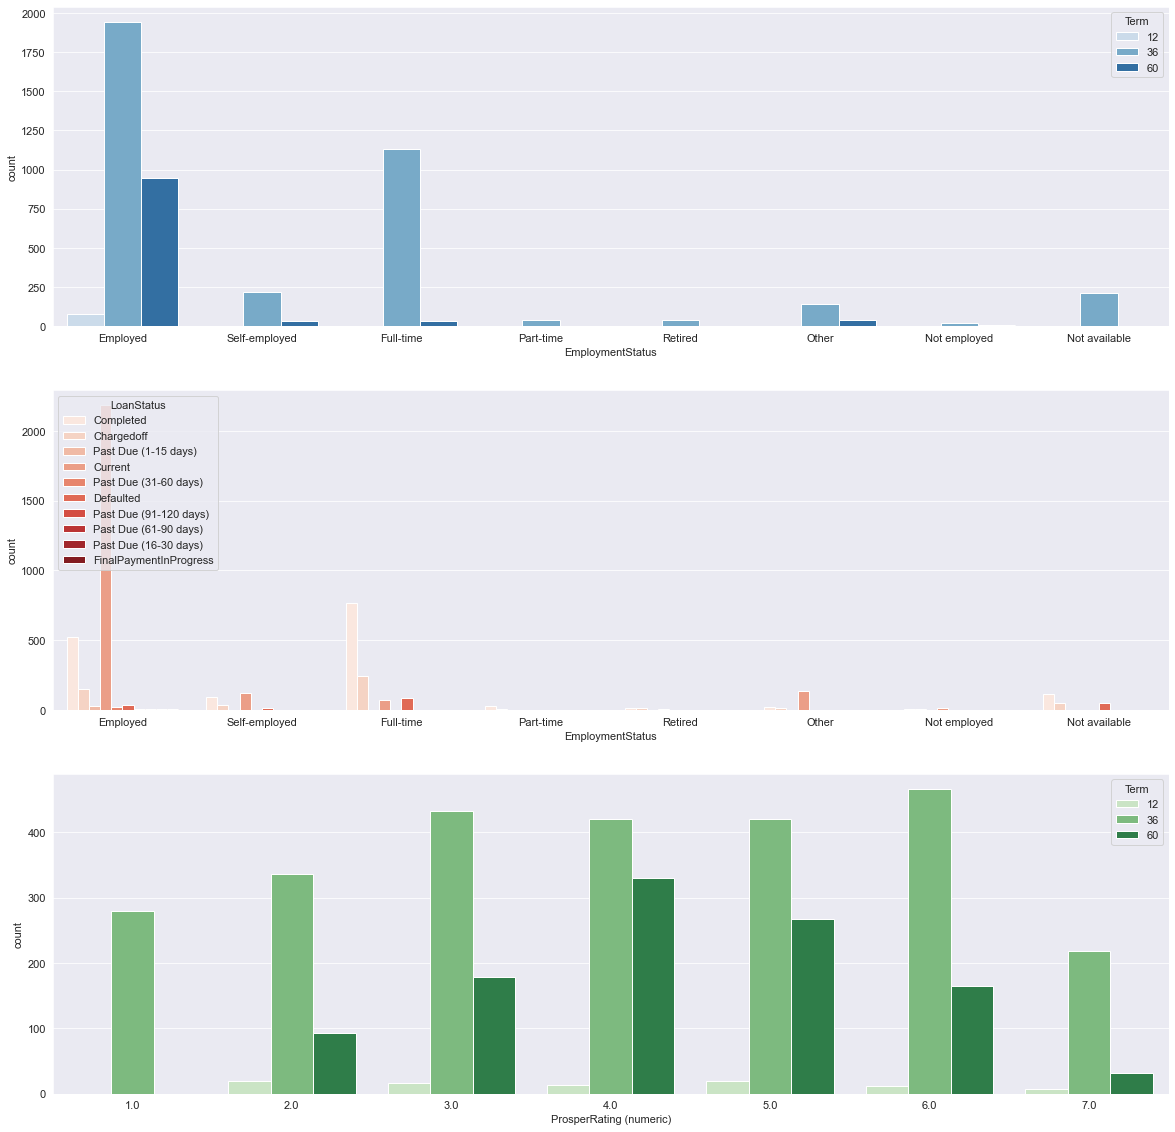

In [30]:
# since there's only three subplots to create, using the full data should be fine.
plt.figure(figsize = [20, 20])

# subplot 1: Employment Status vs Term
plt.subplot(3, 1, 1)
sns.countplot(data = df_samp, x = 'EmploymentStatus', hue = 'Term', palette = 'Blues')

# subplot 2: EmploymentStatus vs Loan Status
ax = plt.subplot(3, 1, 2)
sns.countplot(data = df_samp, x = 'EmploymentStatus', hue = 'LoanStatus', palette = 'Reds')

# subplot 3: Prosper Rating vs Term
ax = plt.subplot(3, 1, 3)
sns.countplot(data = df_samp, x = 'ProsperRating (numeric)', hue = 'Term', palette = 'Greens')

plt.show()

<b>Observations:</b>
- Across all employment status, 36 months appears to be the most popular term
- Good-standing loan statuses (Completed, current) are dominant amongst employed and full-time employees
- Long-term loans (60 months) are more frequent from the mean point of 4.0 on the ProsperRating, indicating that people with poor ratings opt for longer terms

### Most interesting observations

- Borrowers with No employment status appeared to have a favourable BorrowerAPR (finance cost), this is unexpected because the potential to earn income to service the loan should be a significant driver to the APR
- Borrowers with a good ProsperRating enjoy lower finance costs (BorrowerAPR) and higher loan amounts
- Most loans are for the medium term of 36 months



## 4. Multivariate Exploration


#### 4.1 ProsperRating, BorrowerAPR & Term

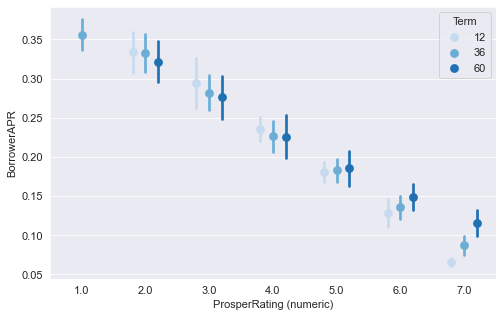

In [31]:
#plot pointplot
fig = plt.figure(figsize = [8,5])
ax = sns.pointplot(data = df, x = 'ProsperRating (numeric)', y = 'BorrowerAPR', hue = 'Term',
                  palette = 'Blues', linestyles = '',dodge = 0.4, ci='sd')

<b>Observations:</b>
- It is interesting to see that a long-term of 60 months attracts the lowest average BorrowerAPR until the mean ProsperRating of 4
- After the mean ProsperRating of 4, 60-months attracts the highest average BorrowerAPR, followed by 36 months, then finally 12 months
- The term of the loan appears to have an impact on BorrowerAPR after from the Mean ProsperRating of 4
- However, across the board, the term of 60 months have the largest interquartile ranges as compared to the other two terms

#### 4.2 ProsperRating, BorrowerAPR & loan amount

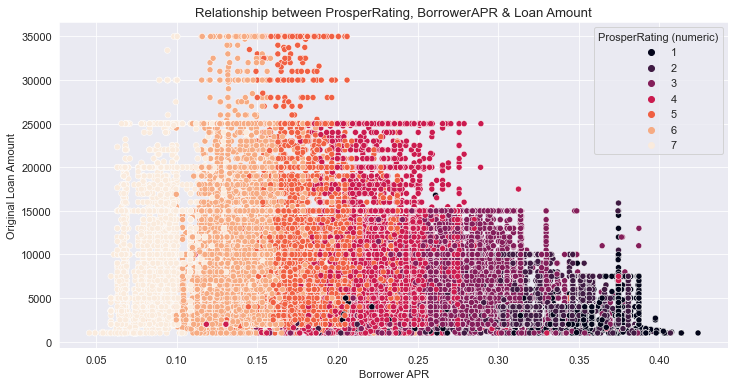

In [32]:
fig = plt.figure(figsize=(12,6))
sns.scatterplot(y='LoanOriginalAmount', x='BorrowerAPR',
                data=df, hue='ProsperRating (numeric)', palette='rocket')
plt.title('Relationship between ProsperRating, BorrowerAPR & Loan Amount')
plt.ylabel('Original Loan Amount')
plt.xlabel('Borrower APR')
plt.show()

<b>Observations</b>:
- Borrowers on the upper end of the ProsperRating (6&7) appear to enjoy the lowest BorrowAPR(Finance cost) at any loan amount
- Loan amounts appear to have little to no impact on BorrowerAPR for borrowers with a high ProsperRating
- Borrowers on the lower end of the ProsperRating (1&2) have higher finance costs, with BorrowerAPR well above the mean of 0.2%
- This means that the Original Loan amount has little impact on the finance cost. Finance cost is largely driven by ProsperRating

#### 4.3 Relationship between Borrower APR and Lender Yield by term

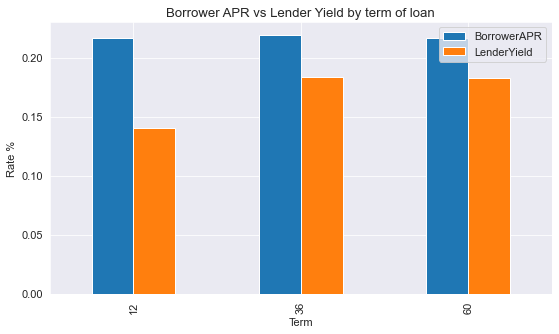

In [33]:
df_pivot = df.pivot_table(index=None, columns='Term', values=['BorrowerAPR', 'LenderYield'],
                                               aggfunc=np.mean)
df_pivot.T.plot(kind='bar', figsize=(9,5), ylabel='Rate %', title='Borrower APR vs Lender Yield by term of loan');

<b>Observations</b>
- BorrowerAPR appear to average slightly above 0.2% regardless of the term, meaning that the term of the loan has little influence on the BorrowerAPR
- However, the term of the loan has a higher impact on the term. Yields for the lenders are higher at 36 months, making it the sweetest spot for the lenders, which could explain why a significant portion of the loans have a term of 36 months. Lenders/investors are more likely to fund loans with the highest return for them.
- 12-month loans are 1% of the population, and this could be caused by the fact that these loans have the lowest yield for the lender

## Conclusions
1. Note that some visualisations were done on a sample of 5000 loans in order to render faster and provide a clearer picture that can be analysed. The sample is random and should still be a good representation of the full population

2. During the investigation, it is clear that the BorrowerAPR and ProsperRatings have the highest correlation
-The higher the ProsperRating the lower the Borrower APR.
3. The term of the loan and loan amount little to no impact on the BorrowerAPR as seen the multivariate analysis
4. The lender's Yield of the loan is impacted by the term of the loan. The highest yield is at 36 months, which explains why over 77% of the loans have a term of 36 months

